In [12]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Feb 1, 2018

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import glob, os
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import pandas as pd
import logging
import yaml
from PIL import Image as pil_image

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, Convolution2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.callbacks import Callback
from NeMO_models import FCN
import NeMO_layers
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

%matplotlib notebook

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

model = load_model('./output/weights_NeMO_AlexNetParallel_hyperas1.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D})

In [13]:
# Test export of patches from gdal
imgpath = '../Images/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI.tif'
tfwpath = '../Images/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI.tfw'
truthpath = '../Images/BIOT-PerosBanhos-sample-habitat-map/BIOT-PerosBanhos-sample-habitat-map.shp'
output_trainpath = '../Images/LO_Training_Patches/'
output_trainrefpath = '../Images/LO_TrainingRef_Patches/'
output_trainfilename = 'rastertrain.txt'
output_validpath = '../Images/LO_Valid_Patches/'
output_validrefpath = '../Images/LO_ValidRef_Patches/'
output_validfilename = 'rastervalid.txt'

PerosBanhos = coralutils.CoralData(imgpath, Truthpath=truthpath, load_type="raster", tfwpath=tfwpath)

with open("init_args - AlexNetParallel_Raster.yml", 'r') as stream:
    try:
        init_args = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])

if train_loader.color_mode == 'rgb':
    num_channels = 3
elif train_loader.color_mode == '8channel':
    num_channels = 8
y = train_loader.target_size[1]
x = train_loader.target_size[0]

pixel_mean =1023.5*np.ones(num_channels)
pixel_std = 1023.5*np.ones(num_channels)
datagen = NeMOImageGenerator(image_shape = (y,x,num_channels),
    image_resample=True, pixelwise_center=True,
    pixel_mean=pixel_mean, pixelwise_std_normalization=True,
    pixel_std=pixel_std)

train_generator = datagen.flow_from_NeMOdirectory(output_trainpath,
    target_size=(y,x),
    color_mode='8channel',
    classes = PerosBanhos.class_labels,
    class_mode = 'categorical',
    batch_size = 120,
    shuffle=True)

Found 48000 images belonging to 24 classes.


{'NoData': 0, 'back reef - pavement': 1, 'back reef - rubble dominated': 2, 'back reef - sediment dominated': 3, 'back reef coral framework': 4, 'Beach': 5, 'Clouds': 6, 'coralline algal ridge (reef crest)': 7, 'deep fore reef slope': 8, 'deep lagoonal water': 9, 'deep ocean water': 10, 'dense seagrass meadows': 11, 'fore reef sand flats': 12, 'Inland waters': 13, 'lagoonal floor - barren': 14, 'lagoonal fringing reefs': 15, 'lagoonal patch reefs': 16, 'lagoonal sediment apron - sediment dominated': 17, 'mangroves': 18, 'Rocky beach': 19, 'shallow fore reef slope': 20, 'shallow fore reef terrace': 21, 'terrestrial vegetation': 22, 'Wetlands': 23}
(51, 851)


<IPython.core.display.Javascript object>


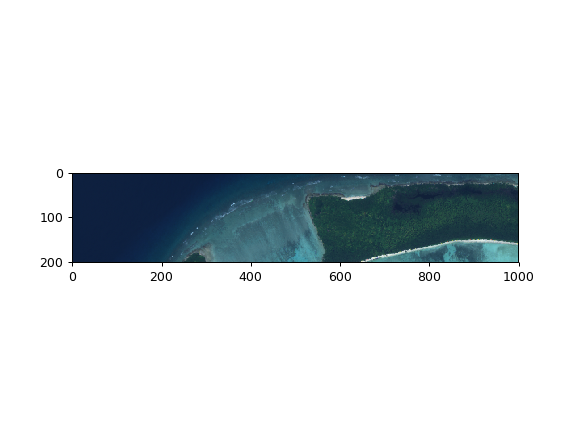

In [14]:
xstart = 500
xlen = 1000
ystart = 400
ylen = 200

PerosBanhos.testimage = PerosBanhos.image[ystart:ystart+ylen,xstart:xstart+xlen,:]
crop_len = int(np.floor(x/2))
if x%2 == 0:
    Testtruth = PerosBanhos.truthimage[ystart+crop_len:ystart+ylen-crop_len+1,xstart+crop_len:xstart+xlen-crop_len+1]
else:
    Testtruth = PerosBanhos.truthimage[ystart+crop_len:ystart+ylen-crop_len,xstart+crop_len:xstart+xlen-crop_len]
print(train_generator.class_indices)
Perostest_RGB = np.rollaxis(np.asarray([1/1016*PerosBanhos.testimage[:,:,4], 1/1543*PerosBanhos.testimage[:,:,2], 1/945*PerosBanhos.testimage[:,:,1]]),0,3)
print(Testtruth.shape)

plt.figure(1)
plt.imshow(Perostest_RGB)
plt.show()

In [15]:
class_indices_rev = dict((v,k) for k,v in train_generator.class_indices.items()) #flip k,v
print(class_indices_rev)

PerosBanhos.set_depth(2047)
print("Total Lines: ", Testtruth.shape[0])
whole_predict, num_predict, truth_predict, accuracy = PerosBanhos.predict_on_whole_image(model, image_size = x, num_lines=None, lastchannelremove=False)
for i in range(whole_predict.shape[0]):
    for j in range(whole_predict.shape[1]):
        whole_predict[i,j] = train_generator.class_indices[class_indices_rev[whole_predict[i,j]]]
        
accuracy = 100*np.asarray((whole_predict == Testtruth)).astype(np.float32).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
print(accuracy)

{0: 'NoData', 1: 'back reef - pavement', 2: 'back reef - rubble dominated', 3: 'back reef - sediment dominated', 4: 'back reef coral framework', 5: 'Beach', 6: 'Clouds', 7: 'coralline algal ridge (reef crest)', 8: 'deep fore reef slope', 9: 'deep lagoonal water', 10: 'deep ocean water', 11: 'dense seagrass meadows', 12: 'fore reef sand flats', 13: 'Inland waters', 14: 'lagoonal floor - barren', 15: 'lagoonal fringing reefs', 16: 'lagoonal patch reefs', 17: 'lagoonal sediment apron - sediment dominated', 18: 'mangroves', 19: 'Rocky beach', 20: 'shallow fore reef slope', 21: 'shallow fore reef terrace', 22: 'terrestrial vegetation', 23: 'Wetlands'}
Total Lines:  51
81.6732333356 850/ 851 completed


<IPython.core.display.Javascript object>


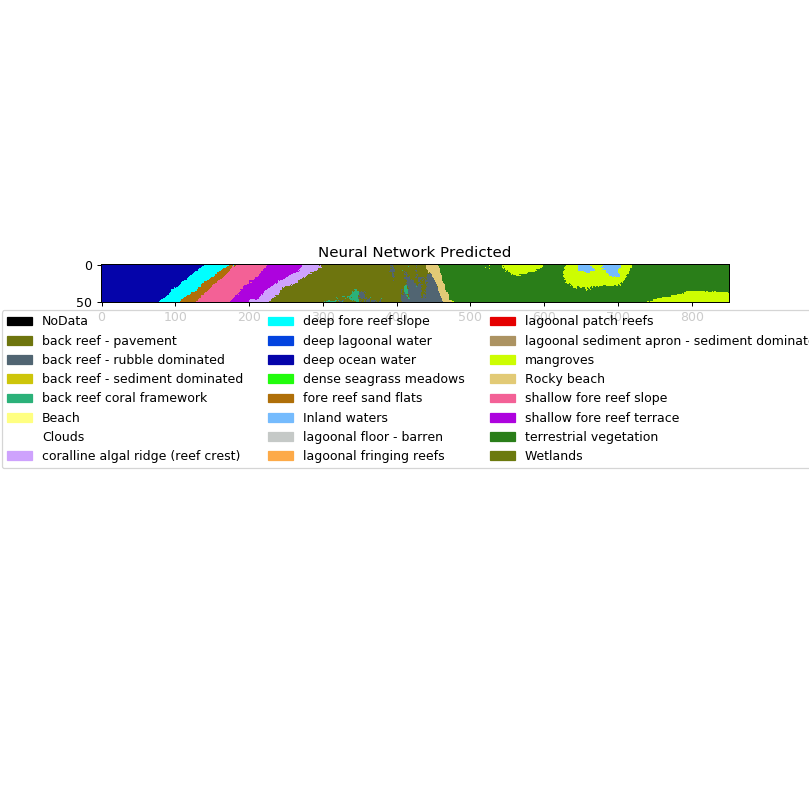

<IPython.core.display.Javascript object>


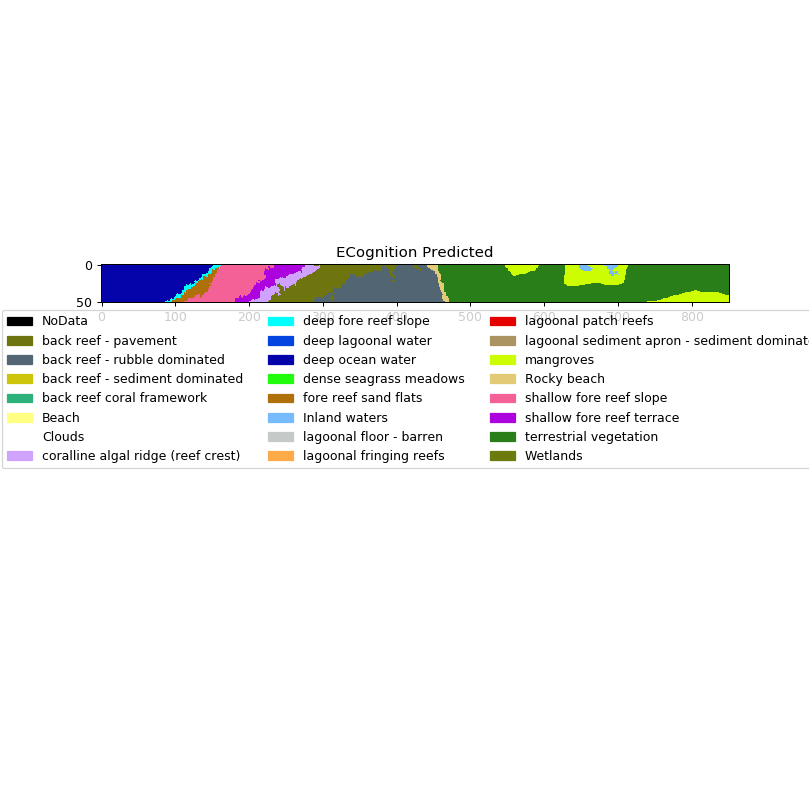

<IPython.core.display.Javascript object>


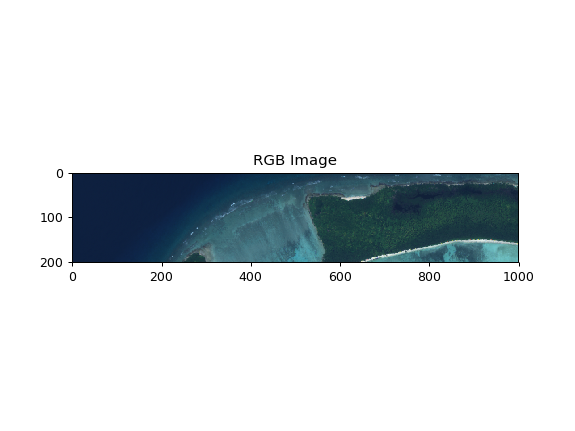

In [16]:
# Colors: 
# NoData: xkcd:black
# back reef - pavement: xkcd:olive
# back reef - rubble dominated: xkcd:slate
# back reef - sediment dominated: xkcd:dirty yellow
# back reef coral framework: xkcd:bluey green
# Beach: xkcd:butter
# Clouds: xkcd:white
# coralline algal ridge (reef crest): xkcd:lilac
# deep fore reef slope: xkcd:cyan
# deep lagoonal water: xkcd:blue
# deep ocean water: xkcd:royal blue
# dense seagrass meadows: xkcd:electric green
# fore reef sand flats: xkcd:caramel
# Inland waters: xkcd:sky blue
# lagoonal floor - barren: xkcd:silver
# lagoonal fringing reefs: xkcd:light orange
# lagoonal patch reef: xkcd:red
# lagoonal sediment apron - sediment dominated: xkcd:dark beige
# mangroves: xkcd:greenish yellow
# Rocky beach: xkcd:sand
# shallow fore reef slope: xkcd:medium pink
# shallow fore reef terrace: xkcd:vibrant purple
# terrestrial vegetation: xkcd:green
# Wetlands: xkcd:murky green
cmap = colors.ListedColormap(['xkcd:black', 'xkcd:olive', 'xkcd:slate', 'xkcd:dirty yellow', 'xkcd:bluey green',
                             'xkcd:butter', 'xkcd:white', 'xkcd:lilac', 'xkcd:cyan', 'xkcd:blue', 'xkcd:royal blue',
                             'xkcd:electric green', 'xkcd:caramel', 'xkcd:sky blue', 'xkcd:silver', 'xkcd:light orange',
                             'xkcd:red', 'xkcd:dark beige', 'xkcd:greenish yellow', 'xkcd:sand',
                             'xkcd:medium pink', 'xkcd:vibrant purple', 'xkcd:tree green', 'xkcd:murky green'])
bounds = [i-0.5 for i in range(25)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap.N)

fig = plt.figure(2,figsize=(9,9))
ax = plt.subplot(111)
ax.imshow(whole_predict, interpolation='nearest', cmap=cmap, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height])
ax.legend([mpatches.Patch(color=cmap(i)) for i in range(24)],
           ['{}'.format(class_indices_rev[i]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
ax.set_title('Neural Network Predicted')

fig = plt.figure(3,figsize=(9,9))
ax = plt.subplot(111)
ax.imshow(Testtruth, interpolation='nearest', cmap=cmap, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height])
ax.legend([mpatches.Patch(color=cmap(i)) for i in range(24)],
           ['{}'.format(class_indices_rev[i]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
ax.set_title('ECognition Predicted')
plt.show()

plt.figure(4)
plt.imshow(Perostest_RGB)
plt.title('RGB Image')
plt.show()

In [10]:
outfile = './output/weights_NeMO_AlexNet_hyperas1.npy'
np.save(outfile,whole_predict)

